Epoch 1/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7233 - loss: 1.3130 - val_accuracy: 0.8127 - val_loss: 0.6573
Epoch 2/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.8154 - loss: 0.6298 - val_accuracy: 0.8244 - val_loss: 0.5767
Epoch 3/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.8274 - loss: 0.5629 - val_accuracy: 0.8343 - val_loss: 0.5354
Epoch 4/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.8365 - loss: 0.5271 - val_accuracy: 0.8424 - val_loss: 0.5102
Epoch 5/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.8426 - loss: 0.5060 - val_accuracy: 0.8458 - val_loss: 0.4950
Epoch 6/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.8461 - loss: 0.4909 - val_accuracy: 0.8477 - val_loss: 0.4833
Epoch 7/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.8496 - loss: 0.4765 - val_accuracy: 0.8494 - val_loss: 0.4812
Epoch 8/100
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 

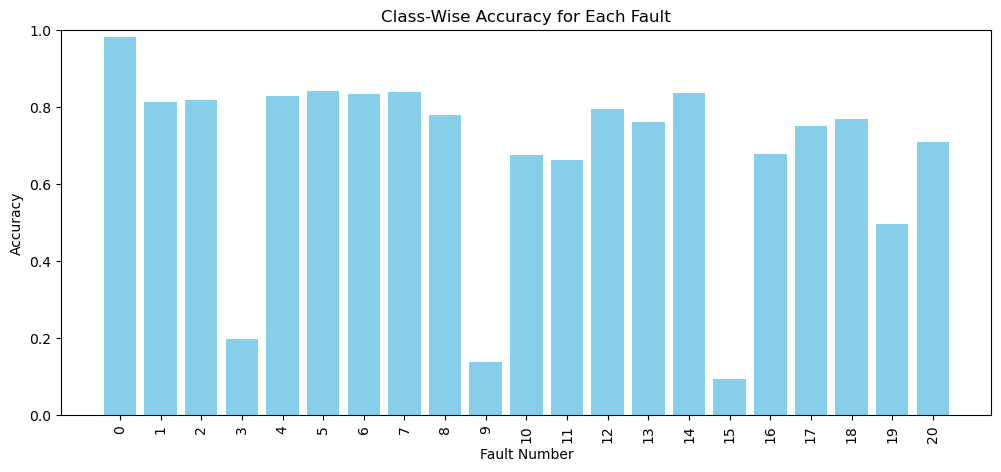

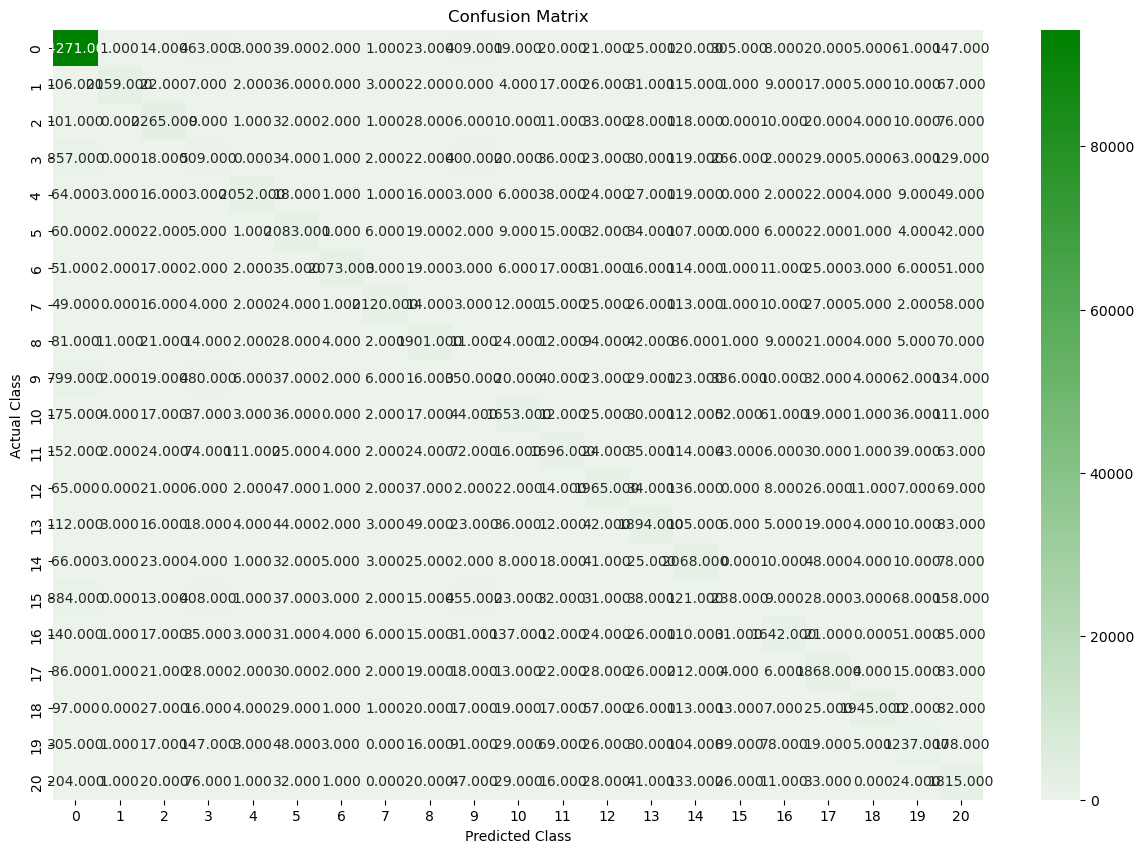

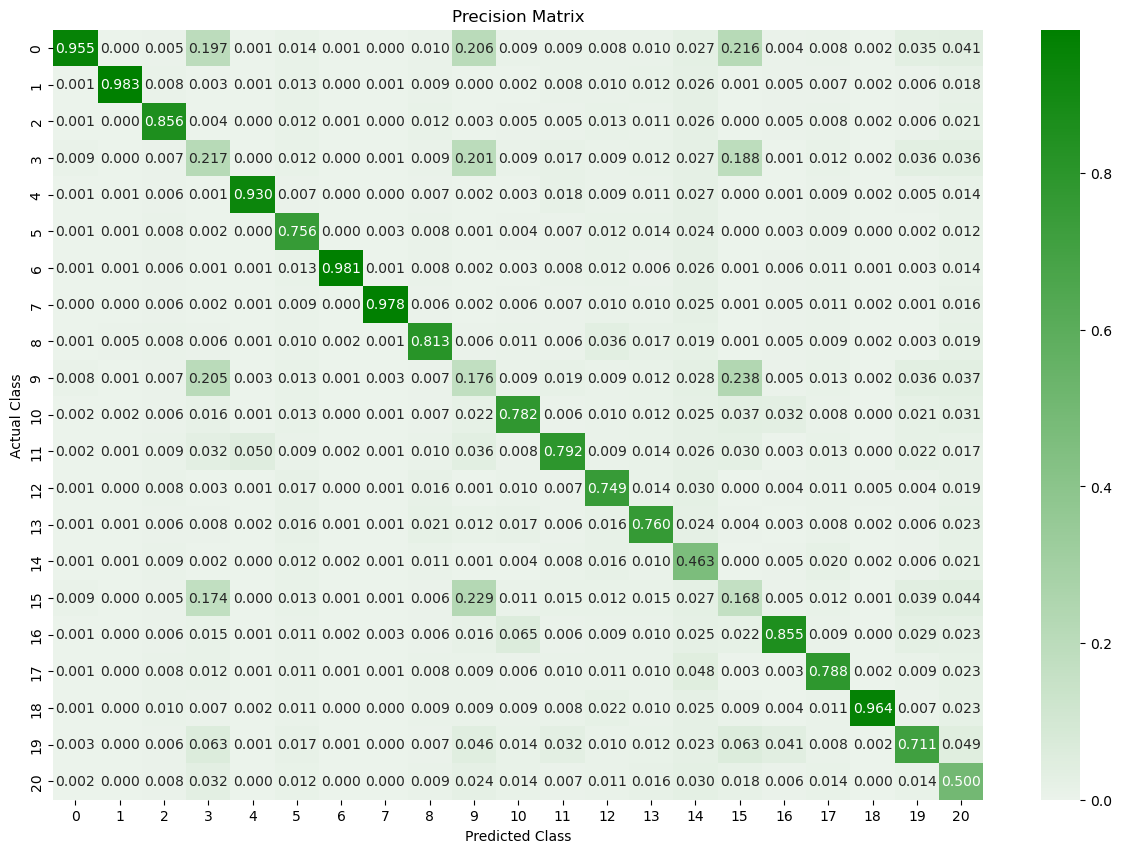

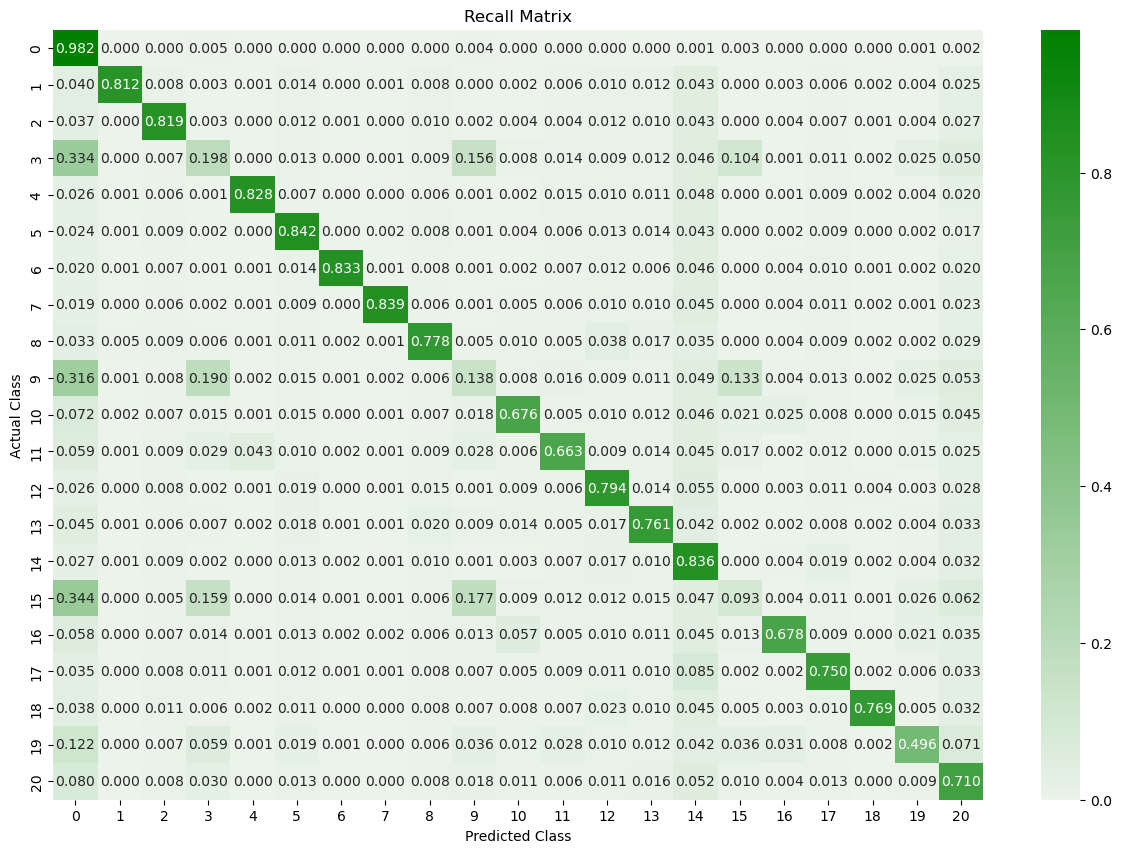

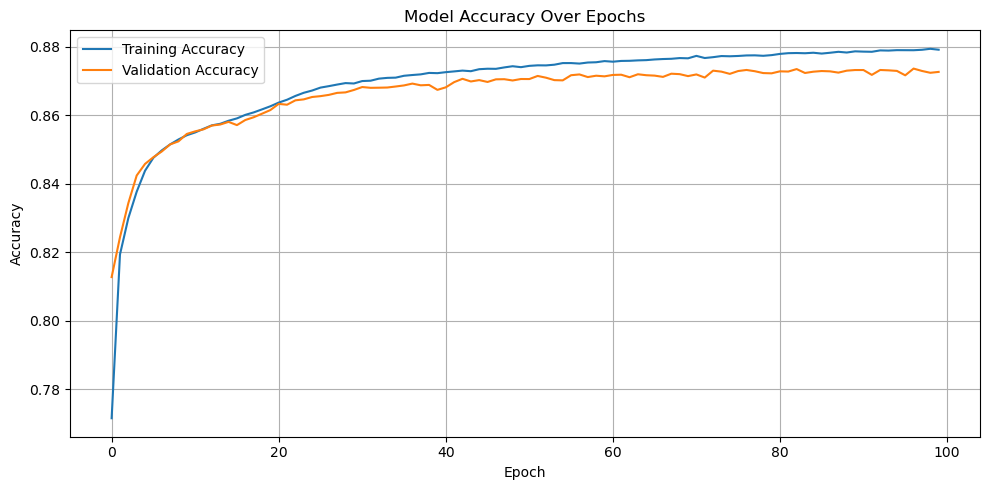

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load Data
df_faulty_free = pd.read_csv('FaultFree_Testing.csv')
df_faulty_train = pd.read_csv('Faulty_Testing.csv')
df_faulty_free['faultNumber'] = 0
df_faulty_train['faultNumber'] = df_faulty_train['faultNumber'].fillna(-1)
df = pd.concat([df_faulty_free, df_faulty_train]).reset_index(drop=True)

# Features and Labels
X = df.drop(columns=['faultNumber']).values
y = df['faultNumber'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model (without regularization)
def CNN_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    output_layer = Dense(len(np.unique(y)), activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train
model = CNN_model(input_shape=(X_train.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test.astype(int)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix and metrics
labels = np.unique(y_true)
C = confusion_matrix(y_true, y_pred, labels=labels)
class_wise_accuracy = C.diagonal() / C.sum(axis=1)
print("\nClass-Wise Accuracy (Per Fault):")
for label, acc in zip(labels, class_wise_accuracy):
    print(f"Fault {label}: {acc:.3f}")
overall_accuracy = C.diagonal().sum() / C.sum()
print(f"\nOverall Average Accuracy: {overall_accuracy:.3f}")
TP = C.diagonal()
Total_Fault_Cases = C.sum(axis=1)
FDR = np.where(Total_Fault_Cases != 0, TP / Total_Fault_Cases, 0)
print("\nFault Detection Rate (FDR) for Each Fault:")
for label, fdr in zip(labels, FDR):
    print(f"Fault {label}: {fdr:.3f}")
overall_FDR = np.sum(TP) / np.sum(Total_Fault_Cases)
print(f"\nOverall FDR: {overall_FDR:.3f}")

# Visualization
cmap = sns.light_palette("green", as_cmap=True)
plt.figure(figsize=(12, 5))
plt.bar(labels, class_wise_accuracy, color='skyblue')
plt.xlabel("Fault Number")
plt.ylabel("Accuracy")
plt.title("Class-Wise Accuracy for Each Fault")
plt.xticks(labels, rotation=90)
plt.ylim(0, 1)
plt.show()

A = C / C.sum(axis=1, keepdims=True)
B = C / C.sum(axis=0, keepdims=True)
plt.figure(figsize=(15, 10))
sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title("Confusion Matrix")
plt.show()
plt.figure(figsize=(15, 10))
sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title("Precision Matrix")
plt.show()
plt.figure(figsize=(15, 10))
sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title("Recall Matrix")
plt.show()

# Accuracy Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
